## VAE Network

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Encoder(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim, latent_dim):
        super().__init__()

#         self.input = nn.Linear(input_dim + label_dim, hidden_dim)
        self.input = nn.Linear(input_dim, hidden_dim)
#         self.bn = nn.BatchNorm1d(hidden_dim)
        
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(0.5)
        
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(0.5)
        
        self.hidden3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        
        self.mu_z = nn.Linear(hidden_dim, latent_dim)
        self.std_z = nn.Linear(hidden_dim, latent_dim)

#     def forward(self, x, label):
    def forward(self, x):
#         out = self.input(torch.cat((x, label), -1))
        out = self.input(x)

        out = self.hidden(out)
        out = self.bn1(out)
        out = F.relu(out)
#         out = self.dropout1(out)
        
        out = self.hidden2(out)
        out = F.relu(out)
        
        out = self.hidden3(out)
        out = F.relu(out)
        
        mu_z = self.mu_z(out)
        std_z = self.std_z(out)

        return mu_z, std_z


class Decoder(nn.Module):
    def __init__(self, latent_dim, label_dim, hidden_dim, output_dim):
        super().__init__()

#         self.input = nn.Linear(latent_dim + label_dim, hidden_dim)
        self.input = nn.Linear(latent_dim, hidden_dim)
#         self.bn = nn.BatchNorm1d(hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(0.2)
        
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(0.5)
        
        self.hidden3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.dropout3 = nn.Dropout(0.5)
        
        self.mu_x = nn.Linear(hidden_dim, output_dim)
        self.std_x = nn.Linear(hidden_dim, output_dim)

#     def forward(self, z, label):
    def forward(self, z):
#         out = self.input(torch.cat((z, label), -1))
        out = self.input(z)

        out = self.hidden(out)
        out = self.bn1(out)
        out = F.relu(out)
#         out = self.dropout1(out)
        
        out = self.hidden2(out)
        out = F.relu(out)
        
        out = self.hidden3(out)
#         out = self.bn3(out)
        out = F.relu(out)
# #         out = self.dropout3(out)
        
        mu_x = self.mu_x(out)
        std_x = self.std_x(out)

        return mu_x, std_x

In [2]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import torch 
import pandas as pd 
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

In [3]:
bos = load_boston()
df = pd.DataFrame(bos.data)
df.columns = bos.feature_names
print(len(bos.feature_names))
df["Price"] = bos.target

data = df[df.columns[:-1]]
# data = data.apply(
#     lambda x: (x - x.mean()) / x.std()
# )

data["Price"] = df.Price

13


In [4]:
from sklearn import preprocessing

# Dataset to numpy
X = torch.tensor(data.drop("Price", axis=1).values).type(torch.float64)
Y = torch.tensor(data["Price"].values).type(torch.float64)

# Split dataset for test and train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,
                                                    random_state=42)

# Standardize 
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = torch.tensor(scaler.transform(X_train)).type(torch.float64)
X_test = torch.tensor(scaler.transform(X_test)).type(torch.float64)

Y_train = Y_train.view(-1, 1)
Y_test = Y_test.view(-1, 1)

In [5]:
def loss_fn(mu_z, std_z, z_sample, mu_x, std_x, x_in):
    S = x_in.shape[0]
    
    # log posterior q(z|x)
    q_z_dist = torch.distributions.Normal(mu_z, torch.exp(std_z))
    log_q_z = q_z_dist.log_prob(z_sample)
    
    # log likelihood p(x|z)
    p_x_dist = torch.distributions.Normal(mu_x, torch.exp(std_x))
    log_p_x = p_x_dist.log_prob(x_in)
    
    # log prior 
    p_z_dist = torch.distributions.Normal(0, 1)
    log_p_z = p_z_dist.log_prob(z_sample)
    
    loss = (1 / S) * (
        torch.sum(log_q_z) - torch.sum(log_p_x) - torch.sum(log_p_z) 
    )
    
    return loss

In [6]:
""" Hyperparameters """
N_EPOCHS = 1200    # N_EPOCHS = 100 overfitted the data so the evaluation was very bad 
BATCH_SIZE = 128
lr = 0.001
INPUT_DIM = X_train.shape[1]
LABEL_DIM = Y_train.shape[1]
LATENT_DIM = 2
HIDDEN_DIM = 5

In [7]:
train_data = torch.utils.data.TensorDataset(X_train, Y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)

In [8]:
encoder = Encoder(INPUT_DIM, LABEL_DIM, HIDDEN_DIM, LATENT_DIM).type(torch.float64)
decoder = Decoder(LATENT_DIM, LABEL_DIM, HIDDEN_DIM, INPUT_DIM).type(torch.float64)

In [9]:
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr, weight_decay=1e-7)

In [10]:
train_loss_avg = []
test_losses = []


for ep in range(N_EPOCHS):
    train_loss_avg.append(0)
    num_batches = 0
    
    for x, y in train_iter:
        # Update the gradient to zero 
        optimizer.zero_grad()
        
        # Forward pass 
        # Encoder
#         mu_z, std_z = encoder(x, y)
        mu_z, std_z = encoder(x)

        # Sample z
        eps = torch.randn_like(std_z)
        z_samples = mu_z + eps * torch.exp(std_z)

        # Decoder
#         mu_x, std_x = decoder(z_samples, y)
        mu_x, std_x = decoder(z_samples)
        eps = torch.randn_like(std_x)

#         x_samples = mu_x + eps * torch.exp(std_x)

#         return mu_z, std_z, z_samples, mu_x, std_x, x_samples
        
        # Loss 
        loss = loss_fn(mu_z, std_z, z_samples, mu_x, std_x, x)
        
        # Backward pass 
        loss.backward()
        
        # Update the weights 
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
    
        num_batches += 1
    
    train_loss_avg[-1] /= num_batches
    
    mu_z, std_z = encoder(X_test)
    
    eps = torch.randn_like(std_z)
    z_samples = mu_z + eps * torch.exp(std_z)

    mu_x, std_x = decoder(z_samples)
    eps = torch.randn_like(std_x)

    loss = loss_fn(mu_z, std_z, z_samples, mu_x, std_x, X_test)

    test_losses.append(loss.item())
    
    print("Epoch [%d / %d] average loss: %f" % (ep+1, N_EPOCHS, train_loss_avg[-1]))
    print("Epoch [%d / %d] test loss: %f" % (ep+1, N_EPOCHS, test_losses[-1]))

Epoch [1 / 1200] average loss: 20.531665
Epoch [1 / 1200] test loss: 20.723868
Epoch [2 / 1200] average loss: 20.443900
Epoch [2 / 1200] test loss: 20.596012
Epoch [3 / 1200] average loss: 20.335899
Epoch [3 / 1200] test loss: 20.492050
Epoch [4 / 1200] average loss: 20.216474
Epoch [4 / 1200] test loss: 20.491105
Epoch [5 / 1200] average loss: 20.119628
Epoch [5 / 1200] test loss: 20.313902
Epoch [6 / 1200] average loss: 20.089526
Epoch [6 / 1200] test loss: 20.284427
Epoch [7 / 1200] average loss: 20.051272
Epoch [7 / 1200] test loss: 20.211580
Epoch [8 / 1200] average loss: 19.945023
Epoch [8 / 1200] test loss: 20.157548
Epoch [9 / 1200] average loss: 19.905589
Epoch [9 / 1200] test loss: 20.097194
Epoch [10 / 1200] average loss: 19.813056
Epoch [10 / 1200] test loss: 19.964879
Epoch [11 / 1200] average loss: 19.756378
Epoch [11 / 1200] test loss: 19.940406
Epoch [12 / 1200] average loss: 19.699858
Epoch [12 / 1200] test loss: 19.917116
Epoch [13 / 1200] average loss: 19.661402
Epoc

Epoch [108 / 1200] average loss: 18.457626
Epoch [108 / 1200] test loss: 18.730586
Epoch [109 / 1200] average loss: 18.464669
Epoch [109 / 1200] test loss: 18.720555
Epoch [110 / 1200] average loss: 18.481740
Epoch [110 / 1200] test loss: 18.756537
Epoch [111 / 1200] average loss: 18.466924
Epoch [111 / 1200] test loss: 18.723727
Epoch [112 / 1200] average loss: 18.450717
Epoch [112 / 1200] test loss: 18.705859
Epoch [113 / 1200] average loss: 18.441283
Epoch [113 / 1200] test loss: 18.706346
Epoch [114 / 1200] average loss: 18.433280
Epoch [114 / 1200] test loss: 18.716887
Epoch [115 / 1200] average loss: 18.468560
Epoch [115 / 1200] test loss: 18.714078
Epoch [116 / 1200] average loss: 18.442310
Epoch [116 / 1200] test loss: 18.698832
Epoch [117 / 1200] average loss: 18.449333
Epoch [117 / 1200] test loss: 18.726099
Epoch [118 / 1200] average loss: 18.440375
Epoch [118 / 1200] test loss: 18.686100
Epoch [119 / 1200] average loss: 18.453643
Epoch [119 / 1200] test loss: 18.678254
Epoc

Epoch [207 / 1200] average loss: 18.299532
Epoch [207 / 1200] test loss: 18.592195
Epoch [208 / 1200] average loss: 18.293302
Epoch [208 / 1200] test loss: 18.619552
Epoch [209 / 1200] average loss: 18.292063
Epoch [209 / 1200] test loss: 18.582950
Epoch [210 / 1200] average loss: 18.311535
Epoch [210 / 1200] test loss: 18.581944
Epoch [211 / 1200] average loss: 18.269269
Epoch [211 / 1200] test loss: 18.551310
Epoch [212 / 1200] average loss: 18.297505
Epoch [212 / 1200] test loss: 18.613854
Epoch [213 / 1200] average loss: 18.304892
Epoch [213 / 1200] test loss: 18.549404
Epoch [214 / 1200] average loss: 18.307084
Epoch [214 / 1200] test loss: 18.561097
Epoch [215 / 1200] average loss: 18.334990
Epoch [215 / 1200] test loss: 18.574302
Epoch [216 / 1200] average loss: 18.271082
Epoch [216 / 1200] test loss: 18.565873
Epoch [217 / 1200] average loss: 18.279515
Epoch [217 / 1200] test loss: 18.595900
Epoch [218 / 1200] average loss: 18.328935
Epoch [218 / 1200] test loss: 18.577463
Epoc

Epoch [312 / 1200] average loss: 18.144298
Epoch [312 / 1200] test loss: 18.453155
Epoch [313 / 1200] average loss: 18.095979
Epoch [313 / 1200] test loss: 18.411519
Epoch [314 / 1200] average loss: 18.160914
Epoch [314 / 1200] test loss: 18.294918
Epoch [315 / 1200] average loss: 18.178580
Epoch [315 / 1200] test loss: 18.459480
Epoch [316 / 1200] average loss: 18.152883
Epoch [316 / 1200] test loss: 18.333717
Epoch [317 / 1200] average loss: 18.119072
Epoch [317 / 1200] test loss: 18.284872
Epoch [318 / 1200] average loss: 18.124775
Epoch [318 / 1200] test loss: 18.465194
Epoch [319 / 1200] average loss: 18.152454
Epoch [319 / 1200] test loss: 18.437926
Epoch [320 / 1200] average loss: 18.126183
Epoch [320 / 1200] test loss: 18.421917
Epoch [321 / 1200] average loss: 18.185952
Epoch [321 / 1200] test loss: 18.441266
Epoch [322 / 1200] average loss: 18.140692
Epoch [322 / 1200] test loss: 18.389469
Epoch [323 / 1200] average loss: 18.167675
Epoch [323 / 1200] test loss: 18.356044
Epoc

Epoch [417 / 1200] average loss: 16.372948
Epoch [417 / 1200] test loss: 16.318722
Epoch [418 / 1200] average loss: 16.258504
Epoch [418 / 1200] test loss: 16.004966
Epoch [419 / 1200] average loss: 16.173326
Epoch [419 / 1200] test loss: 15.956817
Epoch [420 / 1200] average loss: 16.099720
Epoch [420 / 1200] test loss: 15.844166
Epoch [421 / 1200] average loss: 16.066731
Epoch [421 / 1200] test loss: 15.729146
Epoch [422 / 1200] average loss: 16.161929
Epoch [422 / 1200] test loss: 15.717172
Epoch [423 / 1200] average loss: 15.995898
Epoch [423 / 1200] test loss: 15.765070
Epoch [424 / 1200] average loss: 16.071625
Epoch [424 / 1200] test loss: 15.579506
Epoch [425 / 1200] average loss: 15.955109
Epoch [425 / 1200] test loss: 15.891777
Epoch [426 / 1200] average loss: 15.821502
Epoch [426 / 1200] test loss: 15.593319
Epoch [427 / 1200] average loss: 15.799936
Epoch [427 / 1200] test loss: 15.497851
Epoch [428 / 1200] average loss: 15.829358
Epoch [428 / 1200] test loss: 15.473919
Epoc

Epoch [521 / 1200] average loss: 13.129339
Epoch [521 / 1200] test loss: 12.401830
Epoch [522 / 1200] average loss: 13.037277
Epoch [522 / 1200] test loss: 12.531600
Epoch [523 / 1200] average loss: 13.022921
Epoch [523 / 1200] test loss: 12.449506
Epoch [524 / 1200] average loss: 13.070282
Epoch [524 / 1200] test loss: 12.485848
Epoch [525 / 1200] average loss: 12.911335
Epoch [525 / 1200] test loss: 12.393741
Epoch [526 / 1200] average loss: 12.933717
Epoch [526 / 1200] test loss: 12.347664
Epoch [527 / 1200] average loss: 12.915648
Epoch [527 / 1200] test loss: 12.386642
Epoch [528 / 1200] average loss: 12.951749
Epoch [528 / 1200] test loss: 12.316566
Epoch [529 / 1200] average loss: 12.884420
Epoch [529 / 1200] test loss: 12.362127
Epoch [530 / 1200] average loss: 12.917695
Epoch [530 / 1200] test loss: 12.270918
Epoch [531 / 1200] average loss: 12.966014
Epoch [531 / 1200] test loss: 12.221722
Epoch [532 / 1200] average loss: 12.917946
Epoch [532 / 1200] test loss: 12.258975
Epoc

Epoch [626 / 1200] average loss: 10.129207
Epoch [626 / 1200] test loss: 9.693087
Epoch [627 / 1200] average loss: 10.184588
Epoch [627 / 1200] test loss: 9.503667
Epoch [628 / 1200] average loss: 10.089391
Epoch [628 / 1200] test loss: 13.355201
Epoch [629 / 1200] average loss: 10.056247
Epoch [629 / 1200] test loss: 9.559909
Epoch [630 / 1200] average loss: 10.167703
Epoch [630 / 1200] test loss: 9.345107
Epoch [631 / 1200] average loss: 9.919477
Epoch [631 / 1200] test loss: 9.379521
Epoch [632 / 1200] average loss: 10.017998
Epoch [632 / 1200] test loss: 9.499798
Epoch [633 / 1200] average loss: 10.039033
Epoch [633 / 1200] test loss: 9.551992
Epoch [634 / 1200] average loss: 10.046487
Epoch [634 / 1200] test loss: 9.457402
Epoch [635 / 1200] average loss: 9.892669
Epoch [635 / 1200] test loss: 9.297564
Epoch [636 / 1200] average loss: 9.835883
Epoch [636 / 1200] test loss: 9.509628
Epoch [637 / 1200] average loss: 9.798050
Epoch [637 / 1200] test loss: 9.313946
Epoch [638 / 1200] 

Epoch [731 / 1200] average loss: 8.139314
Epoch [731 / 1200] test loss: 8.623994
Epoch [732 / 1200] average loss: 8.770131
Epoch [732 / 1200] test loss: 7.414835
Epoch [733 / 1200] average loss: 8.313402
Epoch [733 / 1200] test loss: 7.583396
Epoch [734 / 1200] average loss: 8.166690
Epoch [734 / 1200] test loss: 7.697015
Epoch [735 / 1200] average loss: 8.140110
Epoch [735 / 1200] test loss: 7.860620
Epoch [736 / 1200] average loss: 8.061610
Epoch [736 / 1200] test loss: 7.861610
Epoch [737 / 1200] average loss: 8.018995
Epoch [737 / 1200] test loss: 7.418064
Epoch [738 / 1200] average loss: 7.791945
Epoch [738 / 1200] test loss: 7.702798
Epoch [739 / 1200] average loss: 7.792832
Epoch [739 / 1200] test loss: 7.344652
Epoch [740 / 1200] average loss: 7.724104
Epoch [740 / 1200] test loss: 7.209091
Epoch [741 / 1200] average loss: 7.650352
Epoch [741 / 1200] test loss: 7.349280
Epoch [742 / 1200] average loss: 7.648756
Epoch [742 / 1200] test loss: 6.998483
Epoch [743 / 1200] average l

Epoch [836 / 1200] average loss: 6.657948
Epoch [836 / 1200] test loss: 6.469965
Epoch [837 / 1200] average loss: 6.729042
Epoch [837 / 1200] test loss: 6.504844
Epoch [838 / 1200] average loss: 6.654520
Epoch [838 / 1200] test loss: 6.437485
Epoch [839 / 1200] average loss: 6.610783
Epoch [839 / 1200] test loss: 6.491584
Epoch [840 / 1200] average loss: 6.600472
Epoch [840 / 1200] test loss: 6.462564
Epoch [841 / 1200] average loss: 6.580275
Epoch [841 / 1200] test loss: 6.474203
Epoch [842 / 1200] average loss: 6.591800
Epoch [842 / 1200] test loss: 6.432959
Epoch [843 / 1200] average loss: 6.576359
Epoch [843 / 1200] test loss: 6.489553
Epoch [844 / 1200] average loss: 6.519252
Epoch [844 / 1200] test loss: 6.529761
Epoch [845 / 1200] average loss: 6.526901
Epoch [845 / 1200] test loss: 6.316116
Epoch [846 / 1200] average loss: 6.613190
Epoch [846 / 1200] test loss: 6.299416
Epoch [847 / 1200] average loss: 6.496455
Epoch [847 / 1200] test loss: 6.523743
Epoch [848 / 1200] average l

Epoch [941 / 1200] average loss: 5.946839
Epoch [941 / 1200] test loss: 6.246423
Epoch [942 / 1200] average loss: 6.060954
Epoch [942 / 1200] test loss: 6.300109
Epoch [943 / 1200] average loss: 6.015245
Epoch [943 / 1200] test loss: 6.185105
Epoch [944 / 1200] average loss: 5.920998
Epoch [944 / 1200] test loss: 6.403527
Epoch [945 / 1200] average loss: 5.902654
Epoch [945 / 1200] test loss: 6.200308
Epoch [946 / 1200] average loss: 5.934979
Epoch [946 / 1200] test loss: 6.209663
Epoch [947 / 1200] average loss: 5.953791
Epoch [947 / 1200] test loss: 6.236697
Epoch [948 / 1200] average loss: 6.002137
Epoch [948 / 1200] test loss: 6.206945
Epoch [949 / 1200] average loss: 5.934769
Epoch [949 / 1200] test loss: 6.072433
Epoch [950 / 1200] average loss: 5.987061
Epoch [950 / 1200] test loss: 6.145855
Epoch [951 / 1200] average loss: 5.865306
Epoch [951 / 1200] test loss: 6.102875
Epoch [952 / 1200] average loss: 5.926173
Epoch [952 / 1200] test loss: 6.175654
Epoch [953 / 1200] average l

Epoch [1046 / 1200] average loss: 5.487266
Epoch [1046 / 1200] test loss: 6.183934
Epoch [1047 / 1200] average loss: 5.522435
Epoch [1047 / 1200] test loss: 6.075672
Epoch [1048 / 1200] average loss: 5.489374
Epoch [1048 / 1200] test loss: 6.106780
Epoch [1049 / 1200] average loss: 5.500051
Epoch [1049 / 1200] test loss: 6.070728
Epoch [1050 / 1200] average loss: 5.485244
Epoch [1050 / 1200] test loss: 6.261166
Epoch [1051 / 1200] average loss: 5.497092
Epoch [1051 / 1200] test loss: 6.116088
Epoch [1052 / 1200] average loss: 5.469843
Epoch [1052 / 1200] test loss: 6.006138
Epoch [1053 / 1200] average loss: 5.500211
Epoch [1053 / 1200] test loss: 5.995142
Epoch [1054 / 1200] average loss: 5.446407
Epoch [1054 / 1200] test loss: 5.946005
Epoch [1055 / 1200] average loss: 5.541529
Epoch [1055 / 1200] test loss: 5.884726
Epoch [1056 / 1200] average loss: 5.476530
Epoch [1056 / 1200] test loss: 6.071238
Epoch [1057 / 1200] average loss: 5.383015
Epoch [1057 / 1200] test loss: 5.958599
Epoc

Epoch [1151 / 1200] average loss: 5.196478
Epoch [1151 / 1200] test loss: 5.986115
Epoch [1152 / 1200] average loss: 5.181496
Epoch [1152 / 1200] test loss: 6.053622
Epoch [1153 / 1200] average loss: 5.192891
Epoch [1153 / 1200] test loss: 6.029684
Epoch [1154 / 1200] average loss: 5.168918
Epoch [1154 / 1200] test loss: 5.946914
Epoch [1155 / 1200] average loss: 5.183884
Epoch [1155 / 1200] test loss: 6.041263
Epoch [1156 / 1200] average loss: 5.499200
Epoch [1156 / 1200] test loss: 7.044556
Epoch [1157 / 1200] average loss: 7.526692
Epoch [1157 / 1200] test loss: 12.352900
Epoch [1158 / 1200] average loss: 16.174052
Epoch [1158 / 1200] test loss: 11.594683
Epoch [1159 / 1200] average loss: 8.696243
Epoch [1159 / 1200] test loss: 9.648536
Epoch [1160 / 1200] average loss: 7.385645
Epoch [1160 / 1200] test loss: 7.419359
Epoch [1161 / 1200] average loss: 6.446990
Epoch [1161 / 1200] test loss: 6.353955
Epoch [1162 / 1200] average loss: 5.835510
Epoch [1162 / 1200] test loss: 6.641402
E

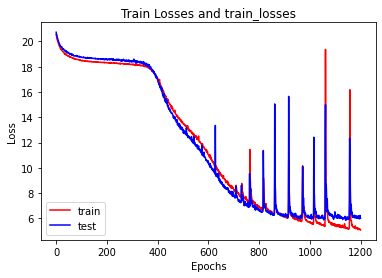

In [11]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg, 'r')
plt.plot(test_losses, 'b')
plt.legend(["train", "test"])
plt.title("Train Losses and train_losses")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Loss function 
$$
\log p(x_i) \geq \int q_\theta(z|x_i) [\log p_\phi(x_i|z) + \log p(z) - \log q_\theta(z|x_i)] dz\\
\approx - \frac{1}{S} \sum_{i=1}^{S} [\log q_\theta(z|x_i) - \log p_\phi(x_i|z) - \log p(z)]\\
= -\frac{1}{S} \sum_{i=1}^S [\mathcal{N}(z|\mu(x_i), \sigma(x_i))- \mathcal{N}(x_i|\mu(z), \sigma(z)) - \mathcal{N}(z|0, 1)]
$$
We add a negative sign to the loss function because the lower bound should be maximized while the loss function should be minimized.

### Test evaluation metrics
$$
\log p(x_i) \geq \int q_\theta(z|x_i) [\log p_\phi(x_i|z) + \log p(z) - \log q_\theta(z|x_i)] dz\\
\approx - \frac{1}{S} \sum_{i=1}^{S} [\log p_\phi(x_i|z)]\\
$$


Should I set $q_\theta(z|x_i)$ to $\mathcal{N}(z|0,1)$ if I am testing with $z\sim q(z)$? So the test evaluation would just be on the term $\log p_\phi(x_i|z)$.
I will be using my trained cVAE for predicting $x$ given just the label. It make sense to test in an environment same as how I will be using the model. So I should just find the error caused by the decoder. 

Referenced for loss function:
https://medium.com/retina-ai-health-inc/variational-inference-derivation-of-the-variational-autoencoder-vae-loss-function-a-true-story-3543a3dc67ee

Tutorial referenced:
https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb#scrollTo=LKnr0LCMhEGj

In [12]:
test_data = torch.utils.data.TensorDataset(X_test, Y_test)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [13]:
def eval_metrics(mu_x, std_x, x_in):
    S = x_in.shape[0]
    
    # log likelihood p(x|z)
    p_x_dist = torch.distributions.Normal(mu_x, torch.exp(std_x))
    log_p_x = p_x_dist.log_prob(x_in)
    
    loss = - (1 / S) * (torch.sum(log_p_x))
    
    return loss 

Sampling

In [14]:
S = X_test.shape[0]
# # Forward pass 
p_z_given_x = torch.distributions.Normal(0, 1)
z = p_z_given_x.sample((S, LATENT_DIM)).type(torch.float64)
# mu_x, std_x = decoder(z, Y_test)   
mu_x, std_x = decoder(z)

In [15]:
eps = torch.distributions.Normal(0, 1).sample(std_x.shape)
x_samples = mu_x + std_x * eps

In [16]:
x_samples.mean(0)

tensor([-0.1732, -0.6447, -0.2819, -1.0721, -0.0884, -0.0129, -0.0944, -0.0159,
        -0.3620, -0.1693,  0.0678,  0.1386, -0.0402], dtype=torch.float64,
       grad_fn=<MeanBackward1>)

In [17]:
X_test.mean(0)

tensor([ 0.0576, -0.0059,  0.0018, -0.0546, -0.0732, -0.1902, -0.0271,  0.0457,
         0.0430,  0.0239,  0.2623, -0.1161,  0.1087], dtype=torch.float64)

In [18]:
x_samples.std(0)

tensor([1.4544, 5.3327, 1.0032, 6.3251, 0.9403, 0.3803, 0.6583, 1.1032, 1.1031,
        1.0371, 0.4633, 1.6238, 0.6320], dtype=torch.float64,
       grad_fn=<StdBackward1>)

In [19]:
X_test.std(0)

tensor([1.1143, 1.1066, 0.9665, 0.9077, 0.9764, 0.9116, 1.0617, 0.9717, 1.0299,
        1.0444, 0.8328, 1.1600, 1.0140], dtype=torch.float64)

Text(0, 0.5, 'Mean of Generated Distribution')

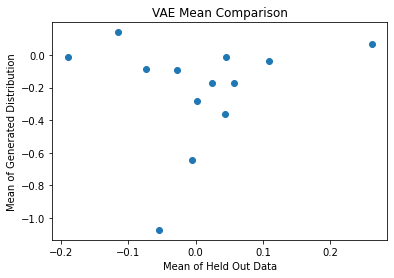

In [20]:
plt.scatter(X_test.mean(0).detach().numpy(), x_samples.mean(0).detach().numpy())
plt.title("VAE Mean Comparison")
plt.xlabel("Mean of Held Out Data")
plt.ylabel("Mean of Generated Distribution")

Text(0, 0.5, 'Standard Deviation of Generated Distribution')

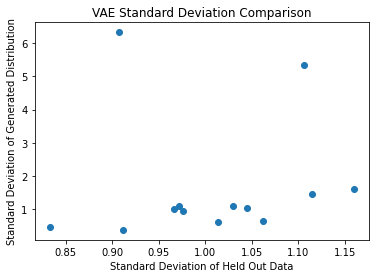

In [21]:
plt.scatter(X_test.std(0).detach().numpy(), x_samples.std(0).detach().numpy())
plt.title("VAE Standard Deviation Comparison")
plt.xlabel("Standard Deviation of Held Out Data")
plt.ylabel("Standard Deviation of Generated Distribution")

In [22]:
# figs, axs = plt.subplots(x_samples.shape[1], 2, figsize=(20, 100))
# for i in range(x_samples.shape[1]):
#     axs[i].scatter([x_test[:,i], x_samples[:,i]], color=['red','green'])
#     axs[i].legend(["data", "sample"])
# plt.show()

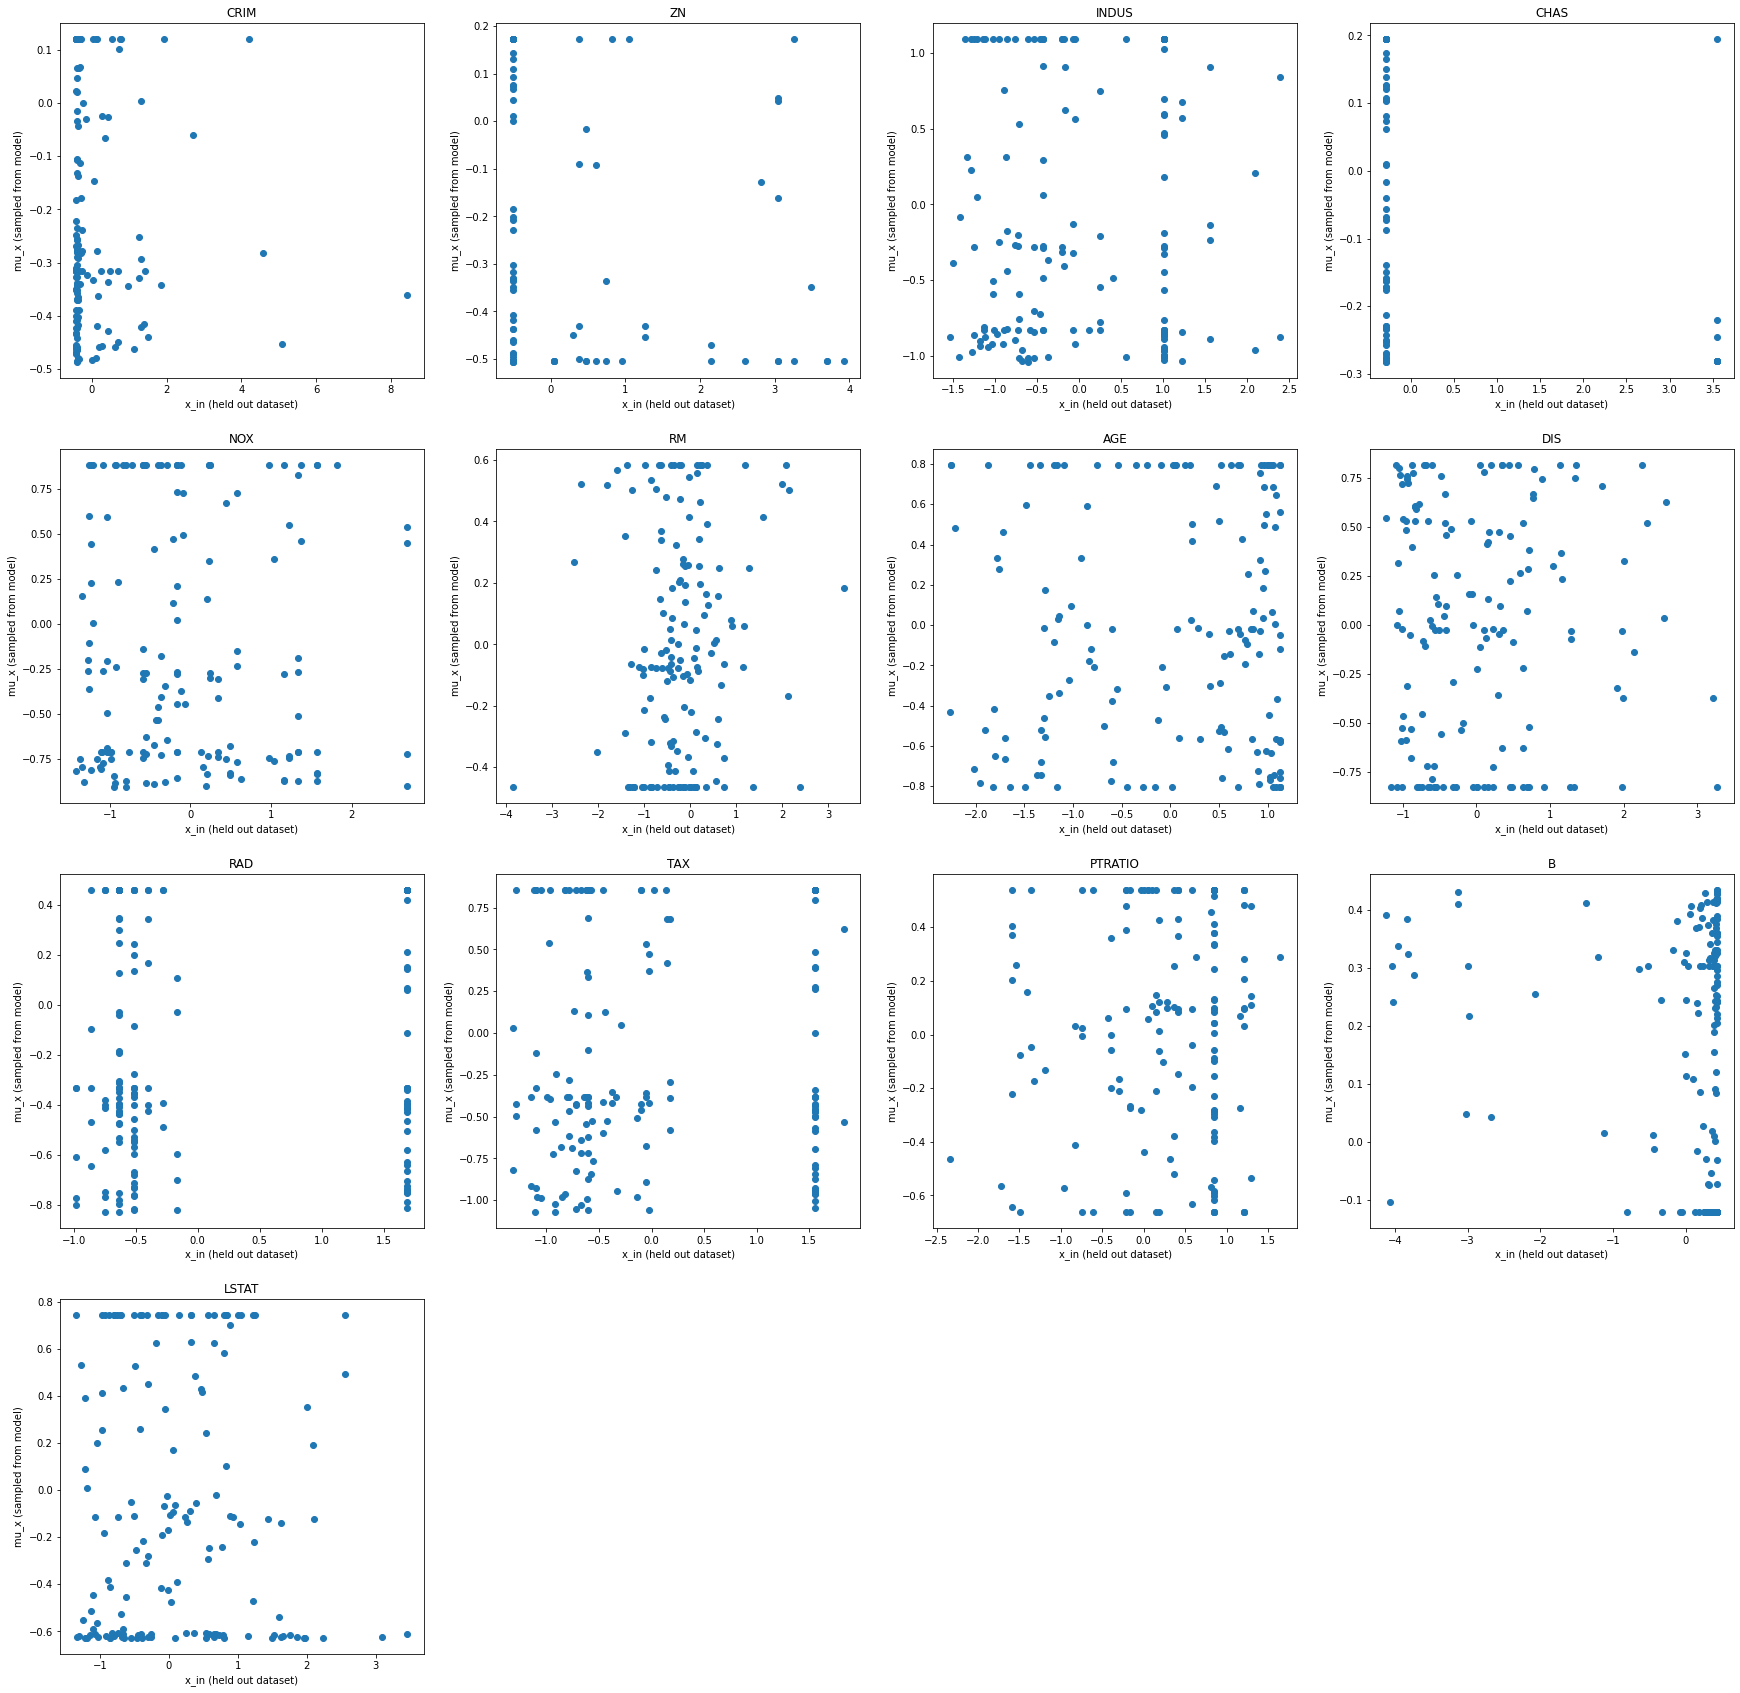

In [23]:
x_test = X_test.detach().numpy()
mu_x = mu_x.detach().numpy()
figs, axs = plt.subplots(4, 4, figsize=(30, 30))
count = 0 
for i in range(4):
    for j in range(4):
        if i*4+j >= 13: 
            break 
        axs[i, j].scatter(x_test[:,i*4+j], mu_x[:,i*4+j])
        axs[i, j].set_title(bos.feature_names[i*4+j])
        axs[i, j].set_ylabel("mu_x (sampled from model)")
        axs[i, j].set_xlabel("x_in (held out dataset)")
    if i*4+j >= 13: 
        break 

plt.delaxes(ax= axs[3,1]) 
plt.delaxes(ax= axs[3,2]) 
plt.delaxes(ax= axs[3,3]) 
        
plt.show()

In [24]:
X_test.shape

torch.Size([152, 13])

In [25]:
x_samples.shape

torch.Size([152, 13])

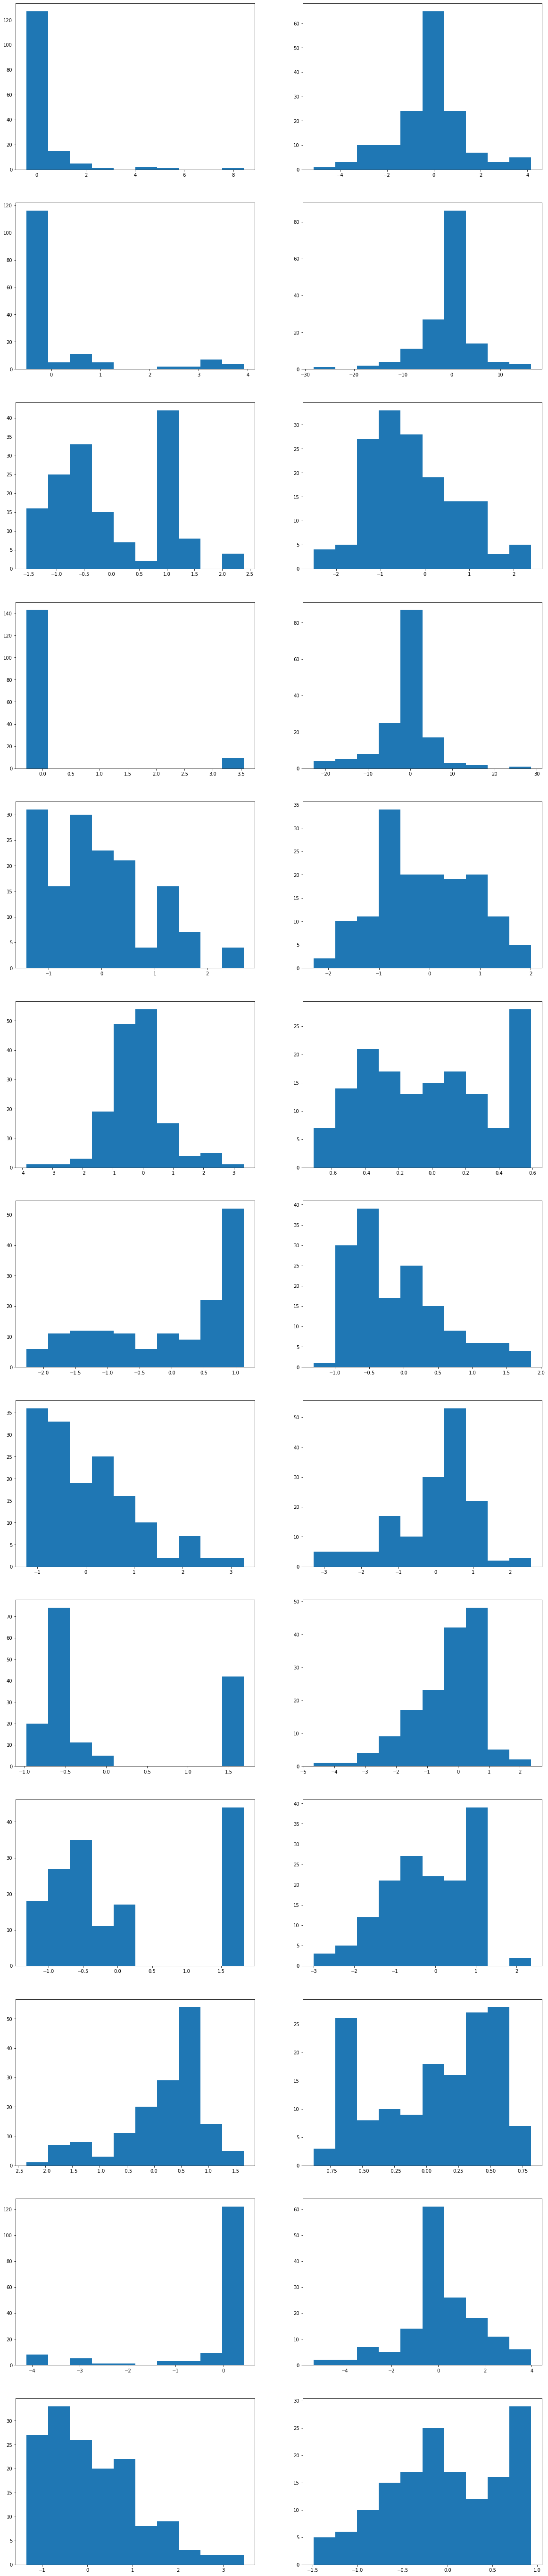

In [26]:
x_samples = x_samples.detach().numpy()
figs, axs = plt.subplots(x_samples.shape[1], 2, figsize=(20, 100))
for i in range(x_samples.shape[1]):
    axs[i, 0].hist(x_test[:,i])
    axs[i, 1].hist(x_samples[:,i])
plt.show()

In [27]:
x_samples.mean(0)

array([-0.173222  , -0.64469631, -0.28193257, -1.07207662, -0.08840499,
       -0.01294594, -0.094374  , -0.01589802, -0.36196975, -0.16934696,
        0.06776975,  0.13860632, -0.04015822])

In [28]:
X_test.mean(0)

tensor([ 0.0576, -0.0059,  0.0018, -0.0546, -0.0732, -0.1902, -0.0271,  0.0457,
         0.0430,  0.0239,  0.2623, -0.1161,  0.1087], dtype=torch.float64)

In [29]:
x_samples.std(0)

array([1.44964566, 5.31515675, 0.99992842, 6.30425807, 0.9371844 ,
       0.37902562, 0.65608631, 1.09960434, 1.09946351, 1.03366461,
       0.46179371, 1.61844304, 0.62990567])

In [30]:
X_test.std(0)

tensor([1.1143, 1.1066, 0.9665, 0.9077, 0.9764, 0.9116, 1.0617, 0.9717, 1.0299,
        1.0444, 0.8328, 1.1600, 1.0140], dtype=torch.float64)

1. What are the 13 features 
2. What does plotting the histogram represent. 

In [31]:
np.corrcoef(X_test, rowvar=False)[0]

array([ 1.        , -0.1910687 ,  0.42486438, -0.08718963,  0.46821577,
       -0.23795259,  0.38613771, -0.40293044,  0.63190985,  0.58463217,
        0.27942462, -0.52906495,  0.55059428])

In [32]:
np.corrcoef(x_samples, rowvar=False)[0]

array([ 1.        ,  0.01286188,  0.11509948,  0.00985813,  0.18403508,
       -0.1293435 ,  0.12770197, -0.14009009,  0.09065191,  0.05759696,
        0.23414154,  0.05477278,  0.18471663])

In [33]:
np.corrcoef(X_test, rowvar=False)[1]

array([-0.1910687 ,  1.        , -0.51290453, -0.06876205, -0.49604812,
        0.34901083, -0.54269001,  0.65072851, -0.29812013, -0.33169892,
       -0.45453415,  0.18209134, -0.45634992])

In [34]:
np.corrcoef(x_samples, rowvar=False)[1]

array([ 0.01286188,  1.        , -0.14466464,  0.05821158, -0.04684106,
        0.16842742, -0.04349328,  0.09073629, -0.03519062, -0.08104448,
       -0.10174572, -0.00990232, -0.0832657 ])

In [35]:
np.corrcoef(X_test, rowvar=False)[2]

array([ 0.42486438, -0.51290453,  1.        ,  0.03220062,  0.76409769,
       -0.35575224,  0.66757595, -0.72731343,  0.63361793,  0.7646962 ,
        0.45750608, -0.41160893,  0.66605524])

In [36]:
np.corrcoef(x_samples, rowvar=False)[2]

array([ 0.11509948, -0.14466464,  1.        , -0.00452643,  0.53275816,
       -0.54911002,  0.50415364, -0.3988181 ,  0.31120561,  0.45173167,
        0.48979604, -0.07085552,  0.5563974 ])

In [37]:
np.corrcoef(X_test, rowvar=False)[3]

array([-0.08718963, -0.06876205,  0.03220062,  1.        ,  0.06471079,
       -0.05183806,  0.09452797, -0.06774048, -0.14252854, -0.15269275,
       -0.21787821, -0.00468345,  0.07728061])

In [38]:
np.corrcoef(x_samples, rowvar=False)[3]

array([ 0.00985813,  0.05821158, -0.00452643,  1.        , -0.05031559,
        0.15575475, -0.04003169,  0.01981752, -0.02342597, -0.05858089,
       -0.09000231,  0.10939395, -0.09076209])